## 230T Trading Project
### 10/11/2018
#### Sumair Ajanee, Anurag Siroliya, Zhaochen (Colin) Xie, Amy Zhou
#### Python 3.6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import collections
from scipy import stats
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, fbeta_score
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import cross_validate, train_test_split

In [2]:
# Function of print performance metrics

def perf_metrics(X, y_true, model, t1, t0):
    y_pred = model.predict(X)
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    f = fbeta_score(y_true, y_pred, average='binary', beta=0.5)
    f1 = f1_score(y_true, y_pred)
    
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    print('-' * 70)
    print('F beta score is: ' + str(f))
    print('-' * 70)
    print('F1 score is: ' + str(f1))
    print('-' * 70)
    print('Classification Report: \n')
    print(classification_report(y_true, y_pred))
    print('-' * 70)
    print("It took {:.2} sec to fit the model.".format(t1 - t0))
    print('-' * 70)

    fpr, tpr, _ = roc_curve(y_pred, y_true, pos_label=1)
    print("Accuracy score: %f" % (accuracy_score(y_true, y_pred)))
    roc_auc = auc(fpr, tpr)
    print("AUC is: %f" % roc_auc)
    print('-' * 70)

# Step1: Load the Data

In [3]:
# stock price
df_AAPL = pd.read_csv("AAPL2005.csv",parse_dates=True,index_col=[0])
df_AAPL.columns = np.array(df_AAPL.columns) +'_AAPL' 

# SP500 index
df_SP500 = pd.read_csv("SP2005.csv",parse_dates=True,index_col=[0])
df_SP500.columns = np.array(df_SP500.columns) +'_SP500' 
df_SP500.head()

# VIX index
df_VIX = pd.read_csv("VIX2005.csv",parse_dates=True,index_col=[0])
df_VIX.columns = np.array(df_VIX.columns) +'_VIX' 
df_VIX.head()



,Open_VIX,High_VIX,Low_VIX,Close_VIX,Adj Close_VIX,Volume_VIX
Date,,,,,,
2005-01-03,13.39,14.23,13.25,14.08,14.08,0
2005-01-04,14.01,14.45,13.93,13.98,13.98,0
2005-01-05,13.98,14.09,13.26,14.09,14.09,0
2005-01-06,14.09,14.09,13.33,13.58,13.58,0
2005-01-07,13.47,13.51,12.94,13.49,13.49,0


In [4]:
#Exchagne rate data
df_Curr = pd.read_csv("CurrencyFeatures.csv",parse_dates=True,index_col=[1])

df_Curr = df_Curr.iloc[:,1:]
df_Curr = df_Curr.apply(pd.to_numeric,downcast='float',errors='coerce')

df_Curr.head()

,USDEUR,USDYuan
Date,,
2005-09-06,1.2483,8.0913
2005-09-07,1.2439,8.0925
2005-09-08,1.2400,8.0945
2005-09-09,1.2433,8.0956
2005-09-12,1.2288,8.0924


In [5]:
# patent data
df_patent = pd.read_csv("CleanPatent3.csv",parse_dates=True,index_col=[0])
df_patent.head()

,totpats
Date,
2006-06-21,1
2006-08-15,2
2007-03-11,3
2007-06-13,4
2007-10-16,6


In [6]:
# GDP data
df_GDP = pd.read_excel("QuarterlyGDP.xls",parse_dates=True,index_col=[0])
df_GDP.head()

,GDPC1
observation_date,
2005-01-01,14771.602
2005-04-01,14839.782
2005-07-01,14972.054
2005-10-01,15066.597
2006-01-01,15267.026


In [7]:
# CPI data
df_CPI = pd.read_csv("CPIAUCSL.csv",parse_dates=True,index_col=[0])
df_CPI.head()

,CPIAUCSL
DATE,
2005-01-01,191.6
2005-02-01,192.4
2005-03-01,193.1
2005-04-01,193.7
2005-05-01,193.6


In [8]:
# AAPL_Fundamental data
df_fdmtl = pd.read_csv("AAPL_Fundamental_Clean.csv",parse_dates=True,index_col=[0])
df_fdmtl.tail()

,Revenue_growth,Gross_Margin,EBITDA_Margin,ROA,Asset_Turnover,Current_Ratio,1yr_share_issue,accrual,asset_growth,div_yield
Date,,,,,,,,,,
2017-06-30,-0.152639,0.436971,0.288980,0.031196,0.131551,1.388342,-0.006946,0.110313,0.031313,0.004374
2017-09-30,0.146628,0.426311,0.296772,0.034957,0.140091,1.276063,-0.008466,-0.132517,0.083731,0.004088
2017-12-31,0.518344,0.415174,0.328667,0.064588,0.217046,1.242011,-0.008729,-0.002762,0.080531,0.003723
2018-03-31,-0.367544,0.427908,0.304775,0.043249,0.166358,1.456034,-0.027607,0.503106,-0.101578,0.003755
2018-06-30,-0.142278,0.430896,0.283637,0.035441,0.151860,1.307325,-0.020512,-0.353898,-0.051093,0.003944


In [9]:
#Daily Treasury Yield Data
df_treasury = pd.read_csv("Daily10YrTreasury.csv", parse_dates=True, index_col=[0])
df_treasury.head()

,DGS10
DATE,
2005-01-03,4.23
2005-01-04,4.29
2005-01-05,4.29
2005-01-06,4.29
2005-01-07,4.29


In [10]:
df_treasury = df_treasury.apply(pd.to_numeric,downcast='float',errors='coerce')
df_treasury.head()

,DGS10
DATE,
2005-01-03,4.23
2005-01-04,4.29
2005-01-05,4.29
2005-01-06,4.29
2005-01-07,4.29


In [11]:
#AQR factor returns Data
df_aqr = pd.read_excel("aqr_factor_returns.xlsx", parse_dates=True, index_col=[0])
df_aqr = df_aqr.loc[df_aqr.index.year>=2006,:]
df_aqr.head()

,BAB,MKT,SMB,UMD,RF,HML
Date,,,,,,
2006-01-02,-0.000139,-0.000160,1.614524e-19,-1.161759e-19,0.00016,-2.880574e-20
2006-01-03,-0.003332,0.016261,-2.597775e-03,1.025627e-02,0.00016,-3.760797e-03
2006-01-04,-0.000282,0.005274,2.070249e-03,2.835798e-03,0.00016,-1.526881e-03
2006-01-05,-0.006217,-0.000490,3.342761e-03,-7.531429e-03,0.00016,6.883171e-04
2006-01-06,-0.000565,0.009639,-1.702536e-04,3.965346e-03,0.00016,-4.823919e-03


In [12]:
#News Data
df_news = pd.read_csv("News Sentiment Data.csv", parse_dates=True, index_col=[0])
df_news = df_news.loc[df_news.index.year>=2006,:]
df_news.head()

,compound,neg,neu,pos
Date,,,,
2006-03-13,-0.0516,0.132,0.69,0.178
2006-03-14,0.0000,0.000,1.00,0.000
2006-03-15,0.0000,0.000,0.00,0.000
2006-03-16,0.0000,0.000,0.00,0.000
2006-03-17,0.0000,0.000,0.00,0.000


In [13]:
# google trends news
# watch out for duplicates.
df_trend = pd.read_csv("google_weekly_trends.csv", parse_dates=True, index_col=[0])
print(df_trend.shape)
df_trend = df_trend[~df_trend.index.duplicated(keep='first')]
df_trend.head()

(666, 1)


,aapl: (Worldwide)
Week,
2006-01-01,31
2006-01-08,72
2006-01-15,55
2006-01-22,49
2006-01-29,40


In [14]:
# df_trend.tail()

In [15]:
#IV Data 
dfIV = pd.read_csv('AAPLIVClean.csv', parse_dates=True, index_col=[0])
dfIV = dfIV.iloc[::-1]
dfIV.head()

,AAPL US Equity Hist Vol (10),AAPL US Equity Hist Vol (30),AAPL US Equity Hist Vol (50),AAPL US Equity Hist Vol (100)
Date,,,,
2000-01-03,63.063870,58.338980,55.738532,64.623352
2000-01-04,80.509331,64.468167,60.012288,66.405002
2000-01-05,79.276051,64.265010,60.040377,66.420850
2000-01-06,91.327787,69.964591,64.009661,68.206787
2000-01-07,93.528546,71.315182,64.645383,68.527751


In [16]:
## AAPL Fut data
dfFut = pd.read_csv('AAPLFutClean.csv', parse_dates=True, index_col=[0])
dfFut.head()

,PX_LAST,FutDiff
Dates,,
2010-12-08,45.8614,0.3971
2010-12-09,45.7043,-0.1571
2010-12-10,45.7971,0.0928
2010-12-13,45.9529,0.1558
2010-12-14,45.7586,-0.1943


# Step 2: Data Health Check

In [17]:
for df in [ df_AAPL,
            df_SP500,
            df_VIX,
            df_Curr,
            df_patent,
            df_GDP,
            df_CPI,
            df_fdmtl,
            df_treasury,
            df_aqr,
            df_news,
            df_trend,
            dfIV,
            dfFut
              ]:
    print (sum(df.index.duplicated(keep='first')))

0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [18]:
# concat won't work if there is any duplicates in any df, join would work.
df_concat = pd.concat([df_AAPL,
                       df_SP500,
                       df_VIX,
                       df_Curr,
                       df_patent,
                       df_GDP,
                       df_CPI,
                       df_fdmtl,
                       df_treasury,
                       df_aqr,
                       df_news,
                       df_trend,
                       dfIV,
                       dfFut
                      ], axis = 1)

In [19]:
# No duplicate, good!
sum(df_concat.index.duplicated(keep='first'))

0

# Step 3: Data Cleaning  & Step 4: Feature Engineering

#### Create labels and construct variables

In [20]:
# forward filling , making sure no NaN value while not creating future-bias
df_concat.fillna(method='ffill',inplace=True) 

# # only the trading dates
list_trading_date = df_AAPL.index
df_concat = df_concat.loc[list_trading_date,:]


In [21]:

# create labels
df_concat['AAPL Adj Close Diff'] = df_concat.loc[:,['Adj Close_AAPL']].diff()
df_concat['Direction'] = df_concat['AAPL Adj Close Diff'].apply(lambda x: 1 if x > 0 else 0)
df_concat.head()

# Return data
df_concat['Return_(t-1)_t_AAPL'] = df_concat[['Adj Close_AAPL']].pct_change(1)
df_concat['Return_(t-2)_t_AAPL'] = df_concat[['Adj Close_AAPL']].pct_change(periods=2)
df_concat['Return_(t-3)_(t-1)_AAPL'] = df_concat[['Adj Close_AAPL']].shift(1)/df_concat[['Adj Close_AAPL']].shift(3) - 1
df_concat['Return_(t-1)_t_SP'] = df_concat[['Adj Close_SP500']].pct_change(1)

# change in price
df_concat['Open_Close_Diff_AAPL'] = df_concat['Close_AAPL']-df_concat['Open_AAPL']
df_concat['High_Low_Diff_AAPL'] = df_concat['High_AAPL']-df_concat['Low_AAPL']
df_concat['Open_Close_Diff_VIX'] = df_concat['Close_VIX']-df_concat['Open_VIX']
df_concat['High_Low_Diff_VIX'] = df_concat['High_VIX']-df_concat['Low_VIX']
df_concat['Chg_in_volume'] = df_concat[['Volume_AAPL']].pct_change(1)

df_concat.columns

Index(['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL', 'Adj Close_AAPL',
       'Volume_AAPL', 'Open_SP500', 'High_SP500', 'Low_SP500', 'Close_SP500',
       'Adj Close_SP500', 'Volume_SP500', 'Open_VIX', 'High_VIX', 'Low_VIX',
       'Close_VIX', 'Adj Close_VIX', 'Volume_VIX', 'USDEUR', 'USDYuan',
       'totpats', 'GDPC1', 'CPIAUCSL', 'Revenue_growth', 'Gross_Margin',
       'EBITDA_Margin', 'ROA', 'Asset_Turnover', 'Current_Ratio',
       '1yr_share_issue', 'accrual', 'asset_growth', 'div_yield', 'DGS10',
       'BAB', 'MKT', 'SMB', 'UMD', 'RF', 'HML', 'compound', 'neg', 'neu',
       'pos', 'aapl: (Worldwide)', 'AAPL US Equity Hist Vol (10)',
       'AAPL US Equity Hist Vol (30)', 'AAPL US Equity Hist Vol (50)',
       'AAPL US Equity Hist Vol (100)', 'PX_LAST', 'FutDiff',
       'AAPL Adj Close Diff', 'Direction', 'Return_(t-1)_t_AAPL',
       'Return_(t-2)_t_AAPL', 'Return_(t-3)_(t-1)_AAPL', 'Return_(t-1)_t_SP',
       'Open_Close_Diff_AAPL', 'High_Low_Diff_AAPL', 'Open_Close

In [22]:

# # select time horizon
df_concat = df_concat.loc[(df_concat.index>='2006-06-30') & (df_concat.index<'2018-07-01'),:]

# check: how many NA is there
print("how many NaN's in df: ",df_concat.isnull().sum().sum()) 

# check: 0 implies no duplicates
print(sum(df_concat.index.duplicated(keep='first')))

how many NaN's in df:  2236
0


In [23]:
df_concat.head(10)

,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,Open_SP500,High_SP500,Low_SP500,Close_SP500,...,Direction,Return_(t-1)_t_AAPL,Return_(t-2)_t_AAPL,Return_(t-3)_(t-1)_AAPL,Return_(t-1)_t_SP,Open_Close_Diff_AAPL,High_Low_Diff_AAPL,Open_Close_Diff_VIX,High_Low_Diff_VIX,Chg_in_volume
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-30,8.227143,8.250000,8.071428,8.181429,7.250839,184923900.0,1272.859985,1276.300049,1270.199951,1270.199951,...,0,-0.028828,0.022314,0.026815,-0.002098,-0.045714,0.178572,0.180000,0.73,-0.153083
2006-07-03,8.217143,8.311429,8.191428,8.278571,7.336932,48692700.0,1270.060059,1280.380005,1270.060059,1280.189941,...,1,0.011874,-0.017297,0.022314,0.007865,0.061428,0.120001,-0.240000,0.74,-0.736688
2006-07-05,8.164286,8.228572,8.080000,8.142858,7.216655,129560200.0,1280.050049,1280.050049,1265.910034,1270.910034,...,0,-0.016393,-0.004714,-0.017297,-0.007249,-0.021428,0.148572,0.230000,0.91,1.660773
2006-07-06,8.155714,8.200000,7.944286,7.967143,7.060928,158302200.0,1270.579956,1278.319946,1270.579956,1274.079956,...,0,-0.021579,-0.037618,-0.004714,0.002494,-0.188571,0.255714,-0.390000,0.79,0.221843
2006-07-07,7.925714,8.078571,7.810000,7.914286,7.014081,199840200.0,1274.079956,1275.380005,1263.130005,1265.479980,...,0,-0.006635,-0.028070,-0.037618,-0.006750,-0.011428,0.268571,0.070000,1.02,0.262397
2006-07-10,7.957143,8.070000,7.785714,7.857143,6.963437,132336400.0,1265.459961,1274.060059,1264.459961,1267.339966,...,0,-0.007220,-0.013807,-0.028070,0.001470,-0.100000,0.284286,-0.150000,0.83,-0.337789
2006-07-11,7.872857,7.998571,7.790000,7.950000,7.045733,206255700.0,1267.260010,1273.640015,1259.650024,1272.430054,...,1,0.011818,0.004513,-0.013807,0.004016,0.077143,0.208571,-1.170000,1.58,0.558571
2006-07-12,7.881429,7.891428,7.560000,7.565714,6.705158,231832300.0,1272.390015,1273.310059,1257.290039,1258.599976,...,0,-0.048338,-0.037091,0.004513,-0.010869,-0.315715,0.331428,1.100000,1.59,0.124004
2006-07-13,7.432857,7.731429,7.344285,7.464286,6.615265,312476500.0,1258.579956,1258.579956,1241.430054,1242.280029,...,0,-0.013407,-0.061096,-0.037091,-0.012967,0.031429,0.387144,2.620001,2.66,0.347856


In [24]:
# making sure each column is in numerical datatype
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2006-06-30 to 2018-06-29
Data columns (total 62 columns):
Open_AAPL                        3021 non-null float64
High_AAPL                        3021 non-null float64
Low_AAPL                         3021 non-null float64
Close_AAPL                       3021 non-null float64
Adj Close_AAPL                   3021 non-null float64
Volume_AAPL                      3021 non-null float64
Open_SP500                       3021 non-null float64
High_SP500                       3021 non-null float64
Low_SP500                        3021 non-null float64
Close_SP500                      3021 non-null float64
Adj Close_SP500                  3021 non-null float64
Volume_SP500                     3021 non-null float64
Open_VIX                         3021 non-null float64
High_VIX                         3021 non-null float64
Low_VIX                          3021 non-null float64
Close_VIX                        3021 non-null flo

% of 0 :  0.4813452443510247


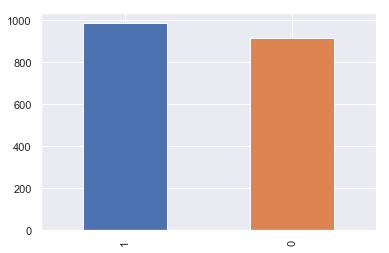

In [102]:
# getting a sense of how many dates AAPL are going up
a = df_concat.Direction.value_counts()
print("% of 0 : ",a[0]/sum(a))
a.plot(kind = 'bar')

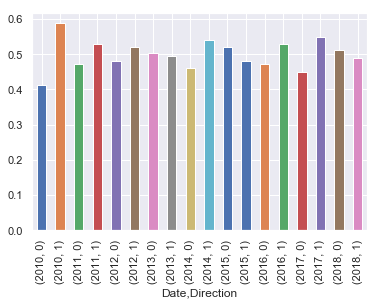

In [101]:
a = df_concat.groupby([df_concat.index.year,'Direction'])['Direction'].count()\
/df_concat.groupby([df_concat.index.year])['Direction'].count()
a.plot(kind = 'bar')

#### Selecting Features, Training, and Testing models.

In [27]:
# Not all features are selected.
# mostly comment out quarterly data, as they introduce more noise than info

Features = [
            'USDEUR',                      
            'USDYuan',                          
            'totpats',                          
            # 'GDPC1',                            
            # 'CPIAUCSL',                         
            # 'Revenue_growth',                   
            # 'Gross_Margin',                     
            # 'EBITDA_Margin',                    
            # 'ROA',                              
            # 'Asset_Turnover',                   
            # 'Current_Ratio',                    
            # '1yr_share_issue',                  
            'accrual',      # Really important feature, improved accuracy from 54.1% to 55.3%
            # 'asset_growth',                     
            # 'div_yield',                        
            'DGS10',                            
            'BAB',                              
            'MKT',                              
            'SMB',                              
            'UMD',                              
            'RF',                               
            'HML',                              
            'compound',                         
            'neg',                              
            'neu',                              
            'pos',                              
            'aapl: (Worldwide)',                
            'AAPL US Equity Hist Vol (10)',     
            'AAPL US Equity Hist Vol (30)',     
            'AAPL US Equity Hist Vol (50)',     
            'AAPL US Equity Hist Vol (100)',    
            'AAPL Adj Close Diff',              
#             'Direction',                        
            'Return_(t-1)_t_AAPL',              
            'Return_(t-2)_t_AAPL',              
            'Return_(t-3)_(t-1)_AAPL',          
            'Return_(t-1)_t_SP',                
            'Open_Close_Diff_AAPL',             
            'High_Low_Diff_AAPL',               
            'Open_Close_Diff_VIX',              
            'High_Low_Diff_VIX',                
            'Chg_in_volume',
            'FutDiff'
            
            ]

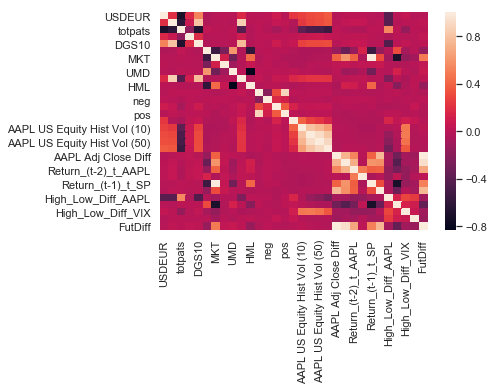

In [28]:

corr = df_concat.loc[:,Features].corr()

#plot the heatmap
sns.heatmap(corr);

In [29]:
# check: how many NA is there
df_concat.dropna(inplace = True)
print("how many NaN's in df: ",df_concat.isnull().sum().sum()) 


how many NaN's in df:  0


# Step 5: Create a dataset for supervised modeling

In [30]:
## Variable reduction using Tree-based method
## by projecting it to the most discriminative directions.
# LDA is not like PCA for feature reduction in the sense that it need y label,
# so LDA actually belongs to linear classification family (close to logistic regression)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

#from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# X and y for supervised learning
# shift 1 day to give it predicting power
y = df_concat[['Direction']].iloc[1:,:].values.T[0]
X = df_concat[Features].iloc[:-1,:].values

### Classification

In [31]:
def clf_result(clf,X_train, X_test, y_train, y_test,n_splits):
    scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
    
    # customize cross validation to time series
    tscv = TimeSeriesSplit(n_splits= n_splits)
    # cross validation result:
    cv_results = cross_validate(clf, X_train, y_train, scoring=scoring, cv=tscv)
    
    print ("training & CV result:")
    for s, r in cv_results.items():
        print (s, r)
        
    # prediction result:
    clf.fit(X_train, y_train)
    print(" ")
    print("accuracy score on test set: ",accuracy_score(y_test, clf.predict(X_test)))
    
    t0 = time.time()
    t1 = time.time()
    print('Performance on training data: \n')
    perf_metrics(X_train, y_train, clf, t1, t0)
    print('Performance on testing data: \n')
    perf_metrics(X_test, y_test, clf, t1, t0)
    return clf

def print_percentage(y,set_name):
    neg = y[y == -1].count()
    pos = y[y == 1].count()
    print ("Percentage of negative sentiment in %s: " % (set_name), (neg*100/(neg+pos)))


In [32]:
def ts_train_test_split(np_x,np_y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits = n_splits)
    for train_index, test_index in tscv.split(np_x):
        X_train, X_test = np_x[train_index], np_x[test_index]
        y_train, y_test = np_y[train_index], np_y[test_index]
#         print("Start of one split")
#         print(X_train)
#         print(X_test)
#         print(y_train)
#         print(y_test)
#         print("End of one split")
    return X_train, X_test, y_train, y_test
# return the last split of data, which is what we want, the test set is 1/k of the whole data

In [33]:
def ts_train_test_standardize(X_train, X_test):
    X_train_mean = X_train.mean()
    X_train_std = X_train.std()
    
    X_train = (X_train - X_train_mean)/X_train_std
    X_test = (X_test - X_train_mean)/X_train_std # to avoid future-bias
    
    return X_train, X_test

### To see how the TS train test works (i.e tscv function)

In [34]:
temp1 = np.array(list(range(0,100,1)))
temp2 = np.array(list(range(1,101,1)))
temp_train, temp_test, temp_y_train, temp_y_test = ts_train_test_split(temp1, temp2, 5)

In [35]:
print(temp_train)
print(temp_test)
print(temp_y_train)
print(temp_y_test)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
[ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100]


In [36]:
# seperate training data from testing data
X_train, X_test, y_train, y_test = ts_train_test_split(X,y,3)

# standardize features
X_train, X_test = ts_train_test_standardize(X_train, X_test)

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1427, 31)
(475, 31)
(1427,)
(475,)


## Feature Transformation Using PCA/LDA

In [38]:
from sklearn.decomposition import PCA

lda = LinearDiscriminantAnalysis(n_components=20)
#lda = lda.fit(X_train,y_train) 
#X_train = lda.transform(X_train)
#X_test = lda.transform(X_test)

#pca = PCA(.80).fit(X_train) 
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

In [39]:
X_train.shape

(1427, 31)

In [40]:
# Naive model:
sum(y_train)/y_train.shape[0]

0.5164681149264191

In [41]:
# Naive model (with future-bias)
sum(y)/y.shape[0]

0.5184016824395373

In [42]:
# truth:
sum(y_test)/y_test.shape[0]

0.5242105263157895

# Step 6: Model selection for supervised learning

### LinearDiscriminantAnalysis (LDA)

training & CV result:
fit_time [0.04614568 0.00200009 0.00360894]
score_time [0.00300026 0.00099969 0.0010004 ]
test_accuracy [0.4747191  0.51685393 0.47752809]
train_accuracy [0.61002786 0.57902098 0.56862745]
test_prec [0.47089947 0.59504132 0.47058824]
train_prec [0.61674009 0.57692308 0.57223796]
 
accuracy score on test set:  0.5263157894736842
Performance on training data: 



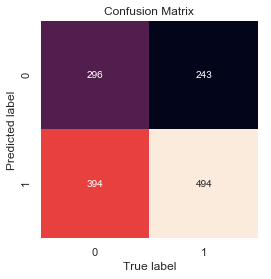

----------------------------------------------------------------------
F beta score is: 0.5758918162741897
----------------------------------------------------------------------
F1 score is: 0.6080000000000001
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.55      0.43      0.48       690
          1       0.56      0.67      0.61       737

avg / total       0.55      0.55      0.55      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.553609
AUC is: 0.552736
----------------------------------------------------------------------
Performance on testing data: 



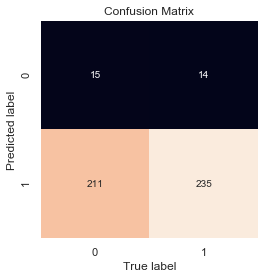

----------------------------------------------------------------------
F beta score is: 0.5779636005902608
----------------------------------------------------------------------
F1 score is: 0.6762589928057554
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.52      0.07      0.12       226
          1       0.53      0.94      0.68       249

avg / total       0.52      0.53      0.41       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.526316
AUC is: 0.522074
----------------------------------------------------------------------


In [43]:
clf = LinearDiscriminantAnalysis()
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

### Logistic Regression

In [44]:
# Do a GridSearchCV
from sklearn.model_selection import GridSearchCV
tscv = TimeSeriesSplit(n_splits= 3)

params = {'penalty': ['l1', 'l2'], 'C': [0.5, 1, 1.1, 1.5, 2, 5]}
grid_clf = GridSearchCV(LogisticRegression(), params, cv=tscv)
grid_clf.fit(X_train, y_train)
# best estimator
best = grid_clf.best_estimator_
print('The best rf is: ')
best

The best rf is: 


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

training & CV result:
fit_time [0.0100081  0.01400971 0.01200819]
score_time [0.00200057 0.00100064 0.00200367]
test_accuracy [0.51404494 0.48876404 0.49719101]
train_accuracy [0.54874652 0.56083916 0.55462185]
test_prec [0.50867052 0.5320197  0.48484848]
train_prec [0.55516014 0.55939525 0.55627426]
 
accuracy score on test set:  0.511578947368421
Performance on training data: 



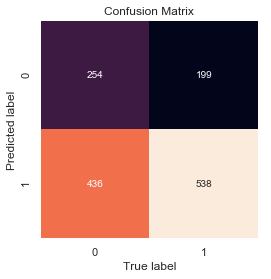

----------------------------------------------------------------------
F beta score is: 0.5806173105978848
----------------------------------------------------------------------
F1 score is: 0.6288720046756282
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.56      0.37      0.44       690
          1       0.55      0.73      0.63       737

avg / total       0.56      0.56      0.54      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.555011
AUC is: 0.556534
----------------------------------------------------------------------
Performance on testing data: 



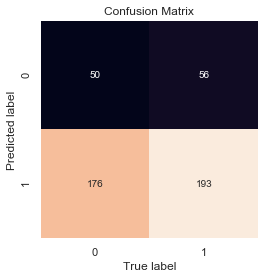

----------------------------------------------------------------------
F beta score is: 0.5594202898550725
----------------------------------------------------------------------
F1 score is: 0.6245954692556633
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.47      0.22      0.30       226
          1       0.52      0.78      0.62       249

avg / total       0.50      0.51      0.47       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.511579
AUC is: 0.497367
----------------------------------------------------------------------


In [45]:
clf = best
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

training & CV result:
fit_time [0.00300217 0.00701046 0.01000619]
score_time [0.00400233 0.00299597 0.00200152]
test_accuracy [0.51685393 0.49719101 0.47191011]
train_accuracy [0.55988858 0.55244755 0.54621849]
test_prec [0.50847458 0.53508772 0.46781116]
train_prec [0.55892256 0.55093555 0.54744526]
 
accuracy score on test set:  0.5052631578947369
Performance on training data: 



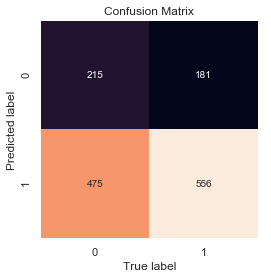

----------------------------------------------------------------------
F beta score is: 0.5718987862579715
----------------------------------------------------------------------
F1 score is: 0.6289592760180995
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.54      0.31      0.40       690
          1       0.54      0.75      0.63       737

avg / total       0.54      0.54      0.52      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.540294
AUC is: 0.541106
----------------------------------------------------------------------
Performance on testing data: 



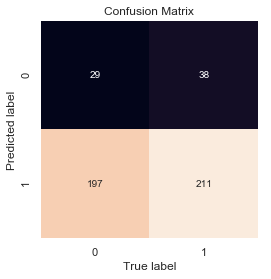

----------------------------------------------------------------------
F beta score is: 0.5608718766613504
----------------------------------------------------------------------
F1 score is: 0.6423135464231355
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.43      0.13      0.20       226
          1       0.52      0.85      0.64       249

avg / total       0.48      0.51      0.43       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.505263
AUC is: 0.474996
----------------------------------------------------------------------


In [46]:
clf = LogisticRegression(penalty='l2', C = 1.1)
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

training & CV result:
fit_time [0.00400233 0.00900626 0.01000547]
score_time [0.00200176 0.00100088 0.00200391]
test_accuracy [0.51404494 0.48876404 0.49719101]
train_accuracy [0.54874652 0.56083916 0.55462185]
test_prec [0.50867052 0.5320197  0.48484848]
train_prec [0.55516014 0.55939525 0.55627426]
 
accuracy score on test set:  0.511578947368421
Performance on training data: 



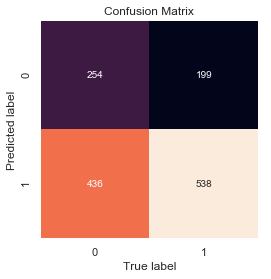

----------------------------------------------------------------------
F beta score is: 0.5806173105978848
----------------------------------------------------------------------
F1 score is: 0.6288720046756282
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.56      0.37      0.44       690
          1       0.55      0.73      0.63       737

avg / total       0.56      0.56      0.54      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.555011
AUC is: 0.556534
----------------------------------------------------------------------
Performance on testing data: 



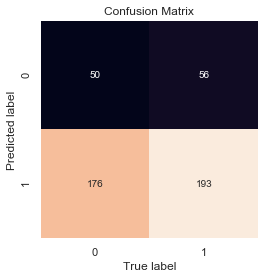

----------------------------------------------------------------------
F beta score is: 0.5594202898550725
----------------------------------------------------------------------
F1 score is: 0.6245954692556633
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.47      0.22      0.30       226
          1       0.52      0.78      0.62       249

avg / total       0.50      0.51      0.47       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.511579
AUC is: 0.497367
----------------------------------------------------------------------


In [47]:
clf = best
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

In [48]:
sum(clf.predict(X_test))/len(clf.predict(X_test))
# perc of time algo predicts positive.

0.7768421052631579

## Random Forest

training & CV result:
fit_time [0.04303098 0.03502488 0.05602288]
score_time [0.00399995 0.00400424 0.00500035]
test_accuracy [0.50842697 0.49157303 0.52247191]
train_accuracy [0.98885794 0.98321678 0.98786181]
test_prec [0.50299401 0.5472973  0.50746269]
train_prec [0.98461538 1.         0.994614  ]
 
accuracy score on test set:  0.5052631578947369
Performance on training data: 



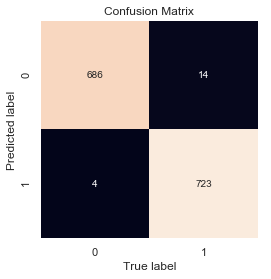

----------------------------------------------------------------------
F beta score is: 0.9917695473251029
----------------------------------------------------------------------
F1 score is: 0.9877049180327868
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       690
          1       0.99      0.98      0.99       737

avg / total       0.99      0.99      0.99      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.987386
AUC is: 0.987249
----------------------------------------------------------------------
Performance on testing data: 



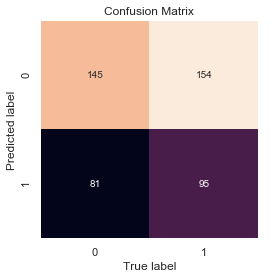

----------------------------------------------------------------------
F beta score is: 0.49842602308499484
----------------------------------------------------------------------
F1 score is: 0.4470588235294118
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.48      0.64      0.55       226
          1       0.54      0.38      0.45       249

avg / total       0.51      0.51      0.50       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.505263
AUC is: 0.512361
----------------------------------------------------------------------


In [49]:
clf = RandomForestClassifier()
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

### SVM 

training & CV result:
fit_time [0.02301717 0.0400281  0.08105803]
score_time [0.01701212 0.02801895 0.04203248]
test_accuracy [0.50561798 0.5505618  0.48595506]
train_accuracy [0.54874652 0.55664336 0.53688142]
test_prec [0.5        0.54929577 0.48595506]
train_prec [0.54441261 0.54333333 0.53359684]
 
accuracy score on test set:  0.5242105263157895
Performance on training data: 



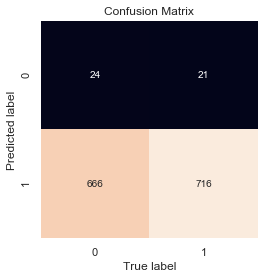

----------------------------------------------------------------------
F beta score is: 0.5714285714285714
----------------------------------------------------------------------
F1 score is: 0.6757904672015103
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.53      0.03      0.07       690
          1       0.52      0.97      0.68       737

avg / total       0.53      0.52      0.38      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.518570
AUC is: 0.525712
----------------------------------------------------------------------
Performance on testing data: 



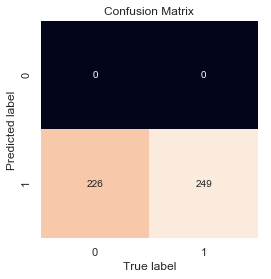

----------------------------------------------------------------------
F beta score is: 0.5793392275476966
----------------------------------------------------------------------
F1 score is: 0.6878453038674033
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       226
          1       0.52      1.00      0.69       249

avg / total       0.27      0.52      0.36       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.524211
AUC is: nan
----------------------------------------------------------------------


C:\Users\colin\AppData\Local\conda\conda\envs\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\colin\AppData\Local\conda\conda\envs\Python36\lib\site-packages\sklearn\metrics\ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\colin\AppData\Local\conda\conda\envs\Python36\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


In [50]:

clf = SVC()
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

### Decision Tree

training & CV result:
fit_time [0.01100779 0.01700544 0.03402424]
score_time [0.00200391 0.00100088 0.00100017]
test_accuracy [0.50842697 0.50280899 0.48033708]
train_accuracy [1. 1. 1.]
test_prec [0.50387597 0.55696203 0.47029703]
train_prec [1. 1. 1.]
 
accuracy score on test set:  0.511578947368421
Performance on training data: 



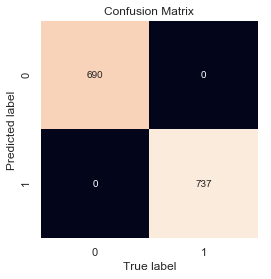

----------------------------------------------------------------------
F beta score is: 1.0
----------------------------------------------------------------------
F1 score is: 1.0
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       690
          1       1.00      1.00      1.00       737

avg / total       1.00      1.00      1.00      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 1.000000
AUC is: 1.000000
----------------------------------------------------------------------
Performance on testing data: 



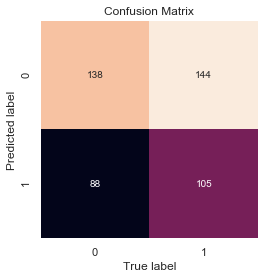

----------------------------------------------------------------------
F beta score is: 0.5142017629774731
----------------------------------------------------------------------
F1 score is: 0.47511312217194573
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.49      0.61      0.54       226
          1       0.54      0.42      0.48       249

avg / total       0.52      0.51      0.51       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.511579
AUC is: 0.516702
----------------------------------------------------------------------


In [51]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt = clf_result(clf_dt,X_train, X_test, y_train, y_test,3)

training & CV result:
fit_time [0.05705619 0.17412519 0.378268  ]
score_time [0.01499176 0.02701879 0.03902936]
test_accuracy [0.51685393 0.49719101 0.47191011]
train_accuracy [0.55988858 0.55244755 0.54621849]
test_prec [0.50847458 0.53508772 0.46781116]
train_prec [0.55892256 0.55093555 0.54744526]
 
accuracy score on test set:  0.5052631578947369
Performance on training data: 



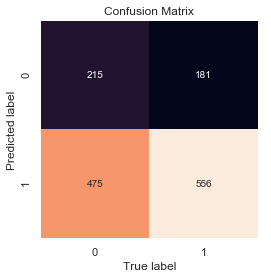

----------------------------------------------------------------------
F beta score is: 0.5718987862579715
----------------------------------------------------------------------
F1 score is: 0.6289592760180995
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.54      0.31      0.40       690
          1       0.54      0.75      0.63       737

avg / total       0.54      0.54      0.52      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.540294
AUC is: 0.541106
----------------------------------------------------------------------
Performance on testing data: 



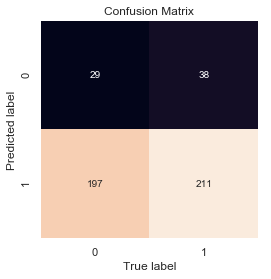

----------------------------------------------------------------------
F beta score is: 0.5608718766613504
----------------------------------------------------------------------
F1 score is: 0.6423135464231355
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.43      0.13      0.20       226
          1       0.52      0.85      0.64       249

avg / total       0.48      0.51      0.43       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.505263
AUC is: 0.474996
----------------------------------------------------------------------


In [52]:
import warnings
warnings.filterwarnings('ignore')

############ Trying ensemble voting with average ##########
# create the sub models
from sklearn.ensemble import VotingClassifier

estimators = []
model1 = LogisticRegression(penalty='l2', C = 1.1)
estimators.append(('logistic', model1))
model2 =  LinearDiscriminantAnalysis()

estimators.append(('lda', model2))
model3 = SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

estimators.append(('svm', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,0,0])


clf = clf_result(ensemble,X_train, X_test, y_train, y_test,3)

# RFE
- might not work as well as we had expected, because different features adds something differently and cutting out half of the features isn't great.

In [53]:
y.shape

(1902,)

In [54]:
X.shape

(1902, 31)

In [55]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# seperate training data from testing data
X_train, X_test, y_train, y_test = ts_train_test_split(X,y,3)

# standardize features
X_train, X_test = ts_train_test_standardize(X_train, X_test)

In [56]:
# feature extraction
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=None, step=3)
fit = rfe.fit(X_train, y_train)
print("Num Features: " + str(fit.n_features_))
print("Selected Features: " + str(fit.support_))
print("Feature Ranking: " + str(fit.ranking_))
print(Features)

d = {}
feature_and_tf = zip(Features, list(fit.ranking_))
print(feature_and_tf)

for f, r in feature_and_tf:
    d[f] = r
print(d)

Num Features: 15
Selected Features: [ True  True False  True  True False False False False False False  True
 False  True  True False  True  True  True False False False False False
 False  True  True  True  True  True False]
Feature Ranking: [1 1 7 1 1 6 3 6 5 5 4 1 7 1 1 7 1 1 1 4 4 5 3 2 3 1 1 1 1 1 6]
['USDEUR', 'USDYuan', 'totpats', 'accrual', 'DGS10', 'BAB', 'MKT', 'SMB', 'UMD', 'RF', 'HML', 'compound', 'neg', 'neu', 'pos', 'aapl: (Worldwide)', 'AAPL US Equity Hist Vol (10)', 'AAPL US Equity Hist Vol (30)', 'AAPL US Equity Hist Vol (50)', 'AAPL US Equity Hist Vol (100)', 'AAPL Adj Close Diff', 'Return_(t-1)_t_AAPL', 'Return_(t-2)_t_AAPL', 'Return_(t-3)_(t-1)_AAPL', 'Return_(t-1)_t_SP', 'Open_Close_Diff_AAPL', 'High_Low_Diff_AAPL', 'Open_Close_Diff_VIX', 'High_Low_Diff_VIX', 'Chg_in_volume', 'FutDiff']
{'USDEUR': 1, 'USDYuan': 1, 'totpats': 7, 'accrual': 1, 'DGS10': 1, 'BAB': 6, 'MKT': 3, 'SMB': 6, 'UMD': 5, 'RF': 5, 'HML': 4, 'compound': 1, 'neg': 7, 'neu': 1, 'pos': 1, 'aapl: (W

In [57]:
new_d = dict((key,value) for key, value in d.items() if value == 1)
list(new_d.keys())

['USDEUR',
 'USDYuan',
 'accrual',
 'DGS10',
 'compound',
 'neu',
 'pos',
 'AAPL US Equity Hist Vol (10)',
 'AAPL US Equity Hist Vol (30)',
 'AAPL US Equity Hist Vol (50)',
 'Open_Close_Diff_AAPL',
 'High_Low_Diff_AAPL',
 'Open_Close_Diff_VIX',
 'High_Low_Diff_VIX',
 'Chg_in_volume']

In [58]:
# Not all features are selected.
selected_features = list(new_d.keys())
X = df_concat[selected_features].iloc[:-1,:].values
y = df_concat[['Direction']].iloc[1:,:].values.T[0]

# seperate training data from testing data
X_train, X_test, y_train, y_test = ts_train_test_split(X,y,3)

# standardize features
X_train, X_test = ts_train_test_standardize(X_train, X_test)

(1427, 15)
(475, 15)
(1427,)
(475,)
training & CV result:
fit_time [0.00400281 0.00200319 0.00600314]
score_time [0.00100136 0.00201821 0.00200319]
test_accuracy [0.51966292 0.53651685 0.49438202]
train_accuracy [0.54874652 0.56083916 0.55275444]
test_prec [0.51012146 0.54545455 0.48186528]
train_prec [0.55363322 0.55646817 0.55227552]
 
accuracy score on test set:  0.49473684210526314
Performance on training data: 



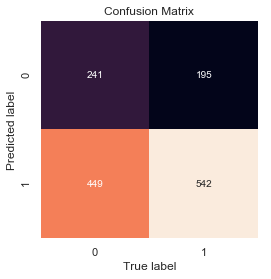

----------------------------------------------------------------------
F beta score is: 0.5764730908317378
----------------------------------------------------------------------
F1 score is: 0.6273148148148149
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.55      0.35      0.43       690
          1       0.55      0.74      0.63       737

avg / total       0.55      0.55      0.53      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.548704
AUC is: 0.549837
----------------------------------------------------------------------
Performance on testing data: 



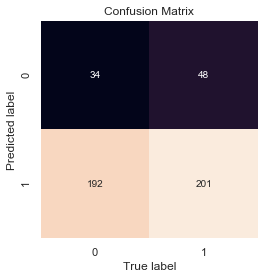

----------------------------------------------------------------------
F beta score is: 0.5518945634266886
----------------------------------------------------------------------
F1 score is: 0.6261682242990654
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.41      0.15      0.22       226
          1       0.51      0.81      0.63       249

avg / total       0.47      0.49      0.43       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.494737
AUC is: 0.463042
----------------------------------------------------------------------


In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
clf = LogisticRegression()
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

## Decision Tree GridSearch

In [60]:
# Do a GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt_params = {'max_depth': [None, 2,5], 'min_samples_leaf': [1, 5],
              'min_samples_split': [2,5], 'max_features': ['log2', None],'random_state':[295]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv = tscv)
grid_dt.fit(X_train, y_train)
# best estimator
dt = grid_dt.best_estimator_
print('The best dt is: ')
dt

The best dt is: 


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=295,
            splitter='best')

training & CV result:
fit_time [0.00300145 0.002002   0.00353146]
score_time [0.00400233 0.00100231 0.00100064]
test_accuracy [0.51685393 0.51966292 0.54775281]
train_accuracy [0.82172702 0.79300699 0.82446312]
test_prec [0.51515152 0.55263158 0.52777778]
train_prec [0.85635359 0.78552972 0.82638889]
 
accuracy score on test set:  0.5010526315789474
Performance on training data: 



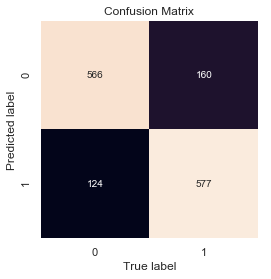

----------------------------------------------------------------------
F beta score is: 0.8147415984185257
----------------------------------------------------------------------
F1 score is: 0.8025034770514602
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.78      0.82      0.80       690
          1       0.82      0.78      0.80       737

avg / total       0.80      0.80      0.80      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.800981
AUC is: 0.801362
----------------------------------------------------------------------
Performance on testing data: 



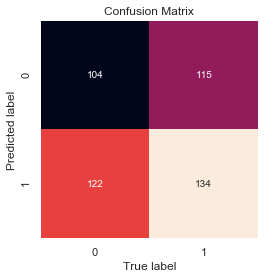

----------------------------------------------------------------------
F beta score is: 0.5263157894736842
----------------------------------------------------------------------
F1 score is: 0.5306930693069307
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.47      0.46      0.47       226
          1       0.52      0.54      0.53       249

avg / total       0.50      0.50      0.50       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.501053
AUC is: 0.499162
----------------------------------------------------------------------


In [61]:
clf = dt
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

### Random forest

In [62]:
# Do a GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators': [10,50,100,200], 'max_depth': [None, 2,5], 'max_leaf_nodes': [None, 5],
              'min_samples_split': [2,5], 'max_features': ['log2', None]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv = tscv)
grid_rf.fit(X_train, y_train)
# best estimator
rf = grid_rf.best_estimator_
print('The best rf is: ')
rf

The best rf is: 


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

training & CV result:
fit_time [0.05503988 0.06804729 0.07907581]
score_time [0.01000619 0.00400329 0.004004  ]
test_accuracy [0.51404494 0.50842697 0.5252809 ]
train_accuracy [0.97493036 0.94125874 0.90102708]
test_prec [0.50724638 0.55376344 0.51086957]
train_prec [0.96464646 0.93139842 0.88945578]
 
accuracy score on test set:  0.5010526315789474
Performance on training data: 



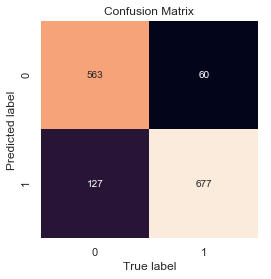

----------------------------------------------------------------------
F beta score is: 0.8563116620288389
----------------------------------------------------------------------
F1 score is: 0.8786502271252434
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.90      0.82      0.86       690
          1       0.84      0.92      0.88       737

avg / total       0.87      0.87      0.87      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.868956
AUC is: 0.872866
----------------------------------------------------------------------
Performance on testing data: 



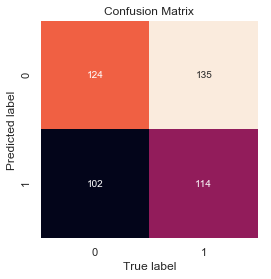

----------------------------------------------------------------------
F beta score is: 0.5121293800539083
----------------------------------------------------------------------
F1 score is: 0.4903225806451612
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.48      0.55      0.51       226
          1       0.53      0.46      0.49       249

avg / total       0.50      0.50      0.50       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.501053
AUC is: 0.503271
----------------------------------------------------------------------


In [63]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

### SVM

In [64]:
# Do a GridSearchCV

svc_params = {'C': [0.5,1,2,5], 'kernel': ['linear','rbf', 'sigmoid','poly']}
grid_svc = GridSearchCV(SVC(), svc_params, cv = tscv)
grid_svc.fit(X_train, y_train)
# best estimator
svc_best = grid_svc.best_estimator_
print('The best svc is: ')
svc_best

The best svc is: 


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

training & CV result:
fit_time [0.01601052 0.03302193 0.07204795]
score_time [0.01801276 0.01300764 0.01901388]
test_accuracy [0.5252809  0.55337079 0.48876404]
train_accuracy [0.55431755 0.55104895 0.54901961]
test_prec [0.51372549 0.55142857 0.4784689 ]
train_prec [0.55339806 0.54181185 0.54397394]
 
accuracy score on test set:  0.5094736842105263
Performance on training data: 



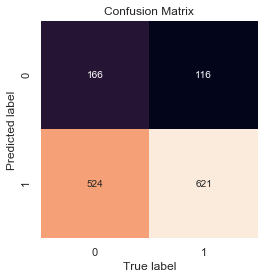

----------------------------------------------------------------------
F beta score is: 0.5839759262742147
----------------------------------------------------------------------
F1 score is: 0.6599362380446334
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.59      0.24      0.34       690
          1       0.54      0.84      0.66       737

avg / total       0.56      0.55      0.51      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.551507
AUC is: 0.565505
----------------------------------------------------------------------
Performance on testing data: 



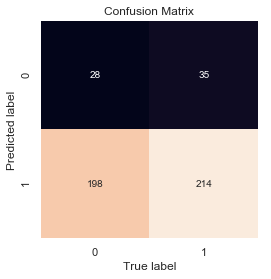

----------------------------------------------------------------------
F beta score is: 0.5640484976278334
----------------------------------------------------------------------
F1 score is: 0.6475037821482602
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.44      0.12      0.19       226
          1       0.52      0.86      0.65       249

avg / total       0.48      0.51      0.43       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.509474
AUC is: 0.481931
----------------------------------------------------------------------


In [65]:
clf = svc_best
clf = clf_result(clf,X_train, X_test, y_train, y_test,3)

## Neural Net

In [66]:
from sklearn.neural_network import MLPClassifier

In [67]:
X_train.shape

(1427, 15)

In [68]:
clfNN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(17, 8, 4, 2), random_state=1)
clfNN.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(17, 8, 4, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [69]:
clfNN.score(X_test, y_test)

0.5389473684210526

## Ensemble Learning

training & CV result:
fit_time [0.4022851  0.4192977  0.50536084]
score_time [0.01300979 0.0130291  0.0110085 ]
test_accuracy [0.52808989 0.54494382 0.51404494]
train_accuracy [0.88022284 0.85734266 0.86181139]
test_prec [0.52702703 0.58638743 0.5       ]
train_prec [0.86057692 0.82962963 0.85738832]
 
accuracy score on test set:  0.5431578947368421
Performance on training data: 



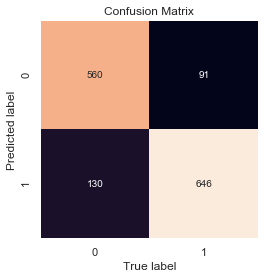

----------------------------------------------------------------------
F beta score is: 0.8409268419682375
----------------------------------------------------------------------
F1 score is: 0.853932584269663
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.86      0.81      0.84       690
          1       0.83      0.88      0.85       737

avg / total       0.85      0.85      0.84      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.845130
AUC is: 0.846345
----------------------------------------------------------------------
Performance on testing data: 



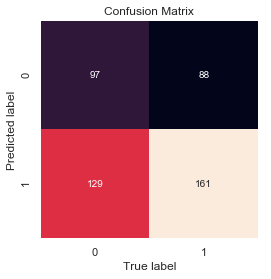

----------------------------------------------------------------------
F beta score is: 0.5713271823988645
----------------------------------------------------------------------
F1 score is: 0.5974025974025974
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.52      0.43      0.47       226
          1       0.56      0.65      0.60       249

avg / total       0.54      0.54      0.54       475

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.543158
AUC is: 0.539748
----------------------------------------------------------------------


In [70]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

############ Trying ensemble voting with average ##########
# create the sub models
from sklearn.ensemble import VotingClassifier

estimators = []
model1 = dt
estimators.append(('dt', model1))
model2 = clfNN
estimators.append(('Neural Net', model2))

model3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.35)

estimators.append(('xgb', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,1,1])


clf_voting = clf_result(ensemble,X_train, X_test, y_train, y_test,3)

### Step 7: Execution

1. count for tranaction cost: assume $\$$5 per transaction, fixed. 
2. implement buy/sell signal to dollar: assume initial trading capital = $\$$10000.
3. Add return comparison to buy-and-hold: 
    - Scenario 1: All-in<br> 


#### use the best model to plot

In [71]:
# Turn buy/sell signal to dollar
def dollar_value(df_concat,y_pred,initial_cash=10000,transaction_cost=5):
    # initialization
    cash = initial_cash
    shares = 0
    df_price = df_concat[["Adj Close_AAPL","Open_AAPL"]]
    NAV = cash
    list_initial = df_price.iloc[0,:].tolist()
    transaction_cost = transaction_cost # assume fixed

    # buy-and-hold strategy: day one buy it and hold it
    hold_share = int((cash-transaction_cost)/list_initial[1]) # buy it at the opening price
    hold_cash = cash - transaction_cost - (hold_share * list_initial[1])
    hold_NAV = hold_cash + hold_share * list_initial[0]
    list_initial.extend([1,shares,cash,NAV,hold_share,hold_cash,hold_NAV])

    # # from day2 to the last training day
    df_NAV = df_price.iloc[1:,:] 
    # # no need for last day, add prediction column to df_NAV
    buy_sell_pred = pd.Series(y_pred[:-1], index = df_NAV.index) 
    df_NAV = df_NAV.assign(buy_sell_pred = buy_sell_pred.values)
    
    
    list_shares = []
    list_cash = []
    list_NAV = []
    list_hold_share = []
    list_hold_cash = []
    list_hold_NAV = []
 
    for index, row in df_NAV.iterrows():
        # if sell signal + there is holding to sell:
        if (row['buy_sell_pred'] == 0) & (shares > 0):
            cash = cash + (shares * row['Open_AAPL']) - transaction_cost # sell it when the market opens 
            shares = 0                                                   # close position
        # if buy signal + there is money to buy:
        elif (row['buy_sell_pred'] == 1) & (cash >= row['Open_AAPL']):
            shares = shares + int((cash-transaction_cost)/row['Open_AAPL'])                 # buy it when the market opens
            cash = cash - (int((cash-transaction_cost)/row['Open_AAPL']) * row['Open_AAPL'])\
                   - transaction_cost                                    # subtract cost of capital
        list_shares.append(shares)
        list_cash.append(cash)
        list_NAV.append(cash + (row['Adj Close_AAPL'] *shares)) # NAV when market closes 
        list_hold_share.append(hold_share)
        list_hold_cash.append(hold_cash)
        list_hold_NAV.append(hold_cash + (row['Adj Close_AAPL'] *hold_share))

    df_NAV['shares'] = list_shares
    df_NAV['cash'] = list_cash
    df_NAV['NAV'] = list_NAV
    df_NAV['hold_share'] = list_hold_share
    df_NAV['hold_cash'] = list_hold_cash
    df_NAV['hold_NAV'] = list_hold_NAV
    
    # add back day-one data
    df_NAV = pd.concat([pd.DataFrame(list_initial,index=df_NAV.columns,\
                                       columns=[df_price.index[0]]).T,df_NAV])
    return df_NAV


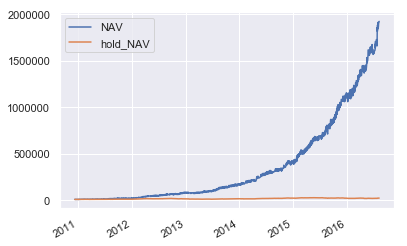

In [108]:
# training set:
df_NAV_train = dollar_value(df_concat.head(X_train.shape[0]),clf_voting.predict(X_train),10000,0)
df_NAV_train[['NAV','hold_NAV']].plot()

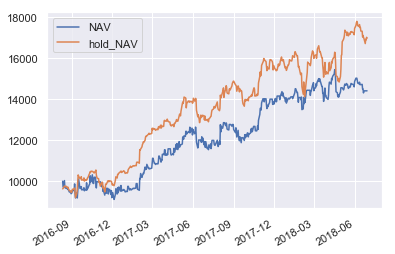

In [109]:
df_NAV_test = dollar_value(df_concat.tail(X_test.shape[0]),clf_voting.predict(X_test),10000,0)
df_NAV_test[['NAV','hold_NAV']].plot()

training & CV result:
fit_time [0.2882061  0.35625482 0.49434972]
score_time [0.01000476 0.01200676 0.01100683]
test_accuracy [0.52808989 0.54494382 0.51404494]
train_accuracy [0.88022284 0.85734266 0.86181139]
test_prec [0.52702703 0.58638743 0.5       ]
train_prec [0.86057692 0.82962963 0.85738832]
 
accuracy score on test set:  0.5405405405405406
Performance on training data: 



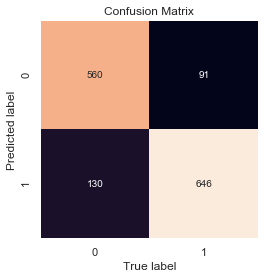

----------------------------------------------------------------------
F beta score is: 0.8409268419682375
----------------------------------------------------------------------
F1 score is: 0.853932584269663
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.86      0.81      0.84       690
          1       0.83      0.88      0.85       737

avg / total       0.85      0.85      0.84      1427

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.845130
AUC is: 0.846345
----------------------------------------------------------------------
Performance on testing data: 



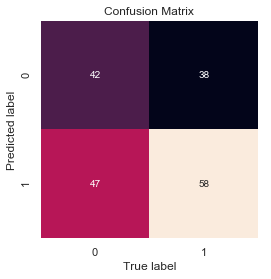

----------------------------------------------------------------------
F beta score is: 0.5620155038759689
----------------------------------------------------------------------
F1 score is: 0.5771144278606964
----------------------------------------------------------------------
Classification Report: 

             precision    recall  f1-score   support

          0       0.53      0.47      0.50        89
          1       0.55      0.60      0.58        96

avg / total       0.54      0.54      0.54       185

----------------------------------------------------------------------
It took 0.0 sec to fit the model.
----------------------------------------------------------------------
Accuracy score: 0.540541
AUC is: 0.538690
----------------------------------------------------------------------


VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_le...     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.35))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1])

In [151]:
clf_result(ensemble,X_train, X_test[-325:-140], y_train, y_test[-325:-140],3)

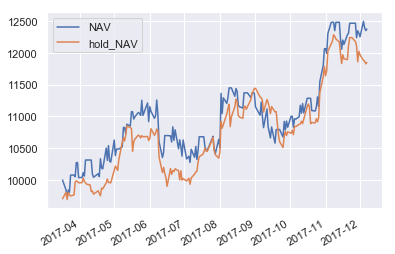

In [155]:
df_NAV_test = dollar_value(df_concat.tail(325),clf_voting.predict(X_test[-325:]),10000,0)
df_NAV_test[['NAV','hold_NAV']].iloc[:-140,:].plot()